# 1. Carregamento do Dataset de energia : Período de 30 dias 



Dataset './data/energy30days.csv' carregado com sucesso.

Dataset 'energy_daily_kwh' (kWh) após preparação inicial (5 primeiras linhas):
                  timestamp  SMV340200  SMV340201  SMV340202  SMV340203  \
0 2025-06-02 21:00:00-03:00  16.949087  17.226529  16.672130   0.000000   
1 2025-06-03 21:00:00-03:00  17.414107  17.701620  17.580698  18.553354   
2 2025-06-04 21:00:00-03:00  17.715928  17.884871  17.540541  13.287821   
3 2025-06-05 21:00:00-03:00  17.809011  17.764612  17.605126  18.773111   
4 2025-06-06 21:00:00-03:00  17.592313  14.592936  17.562198  18.738851   

   SMV340204  SMV340205  SMV340206  SMV340207  SMV340208  ...  SMV340232  \
0  23.209424  22.016507  20.331707  21.045300  24.745333  ...  19.748702   
1  23.447659  22.282449  21.035293  22.078178  25.605770  ...  19.686185   
2  22.644880  22.471000  20.898207  22.201412  25.754032  ...  19.483610   
3  22.805498  22.437053  21.234131  22.214814  25.908580  ...  19.435091   
4  23.174839  22.041154  21.2791

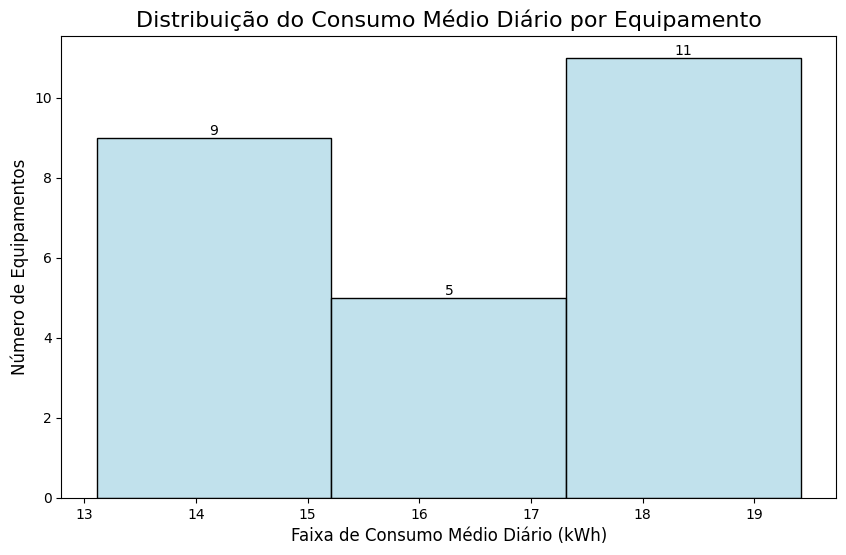


--- Tarefa 1 Concluída ---
Estatísticas Descritivas do Consumo Médio Diário por Equipamento (kWh):
count    25.00
mean     16.40
std       1.98
min      13.11
25%      14.64
50%      16.65
75%      17.87
max      19.42
Name: consumo_medio_kwh, dtype: float64


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression # Para tarefas futuras
from sklearn.model_selection import train_test_split # Para tarefas futuras
from sklearn.metrics import r2_score, mean_squared_error # Para tarefas futuras
import statsmodels.api as sm # Para tarefas futuras
from sklearn.ensemble import RandomForestRegressor # Para tarefas futuras

# --- 0. Carregamento e Preparação Inicial do Dataset 1 ---
# Substitua 'nome_do_seu_arquivo_dataset1.csv' pelo nome real do seu arquivo CSV.
nome_arquivo_dataset1 = './data/energy30days.csv'

try:
    energy_daily_raw = pd.read_csv(nome_arquivo_dataset1)
    print(f"Dataset '{nome_arquivo_dataset1}' carregado com sucesso.")
except FileNotFoundError:
    print(f"\nERRO: O arquivo '{nome_arquivo_dataset1}' não foi encontrado.")
    print("Por favor, verifique o nome do arquivo e se ele está na mesma pasta do seu script/notebook.")
    exit() # Interrompe a execução se o arquivo não for encontrado
except Exception as e:
    print(f"\nOcorreu um erro ao carregar ou processar o arquivo: {e}")
    exit()

# 1. Renomear a coluna de data/hora para 'timestamp' e converter para datetime
energy_daily_raw.rename(columns={"Date and time": "timestamp"}, inplace=True)
energy_daily_raw['timestamp'] = pd.to_datetime(energy_daily_raw['timestamp'])

# 2. Extrair os IDs dos equipamentos dos nomes das colunas
# As colunas de equipamentos começam da segunda coluna em diante (índice 1)
equipment_cols_full_names = energy_daily_raw.columns[1:]
equipment_ids = [col.split(" - Total energy consumed")[0] for col in equipment_cols_full_names]
energy_daily_raw.columns = ['timestamp'] + equipment_ids # Renomear colunas para IDs limpos

# 3. Tratar valores ausentes (strings vazias para NaN) e converter para numérico
# errors='coerce' converterá valores não numéricos (como "") para NaN
for col in equipment_ids:
    energy_daily_raw[col] = pd.to_numeric(energy_daily_raw[col], errors='coerce')

# 4. Preencher NaNs com 0 (assumindo que "sem dados" ou vazio significa "equipamento desligado/consumo 0")
energy_daily_raw.fillna(0, inplace=True)

# 5. Converter de Wh para kWh (dividir por 1000) para facilitar a interpretação em análises futuras
energy_daily_kwh = energy_daily_raw.copy()
for col in equipment_ids:
    energy_daily_kwh[col] = energy_daily_kwh[col] / 1000

print("\nDataset 'energy_daily_kwh' (kWh) após preparação inicial (5 primeiras linhas):")
print(energy_daily_kwh.head())
print(f"Número de equipamentos (colunas): {len(equipment_ids)}")
print(f"Número de dias (linhas): {energy_daily_kwh.shape[0]}")



### **Tarefa 1: Consumos Médios por Equipamento (Histograma com 3 Faixas)**


# Calcular o consumo médio diário para cada equipamento (em kWh)
# Ignoramos a coluna 'timestamp' para esta média
consumo_medio_diario_per_equip = energy_daily_kwh.drop(columns=['timestamp']).mean().reset_index()
consumo_medio_diario_per_equip.columns = ['equipamento_id', 'consumo_medio_kwh']

# Gerar o Histograma com 3 faixas (bins) e fundo transparente
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Definindo 3 bins (faixas) explicitamente
# Você pode ajustar os limites dos bins manualmente se quiser faixas específicas,
# ou deixar o histplot determinar, e depois usar `xticks` para mostrar 3 faixas.
sns.histplot(consumo_medio_diario_per_equip['consumo_medio_kwh'], ax=ax, bins=3, kde=False, color='lightblue', edgecolor='black')

# Opcional: Adicionar rótulos de contagem em cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax.set_title("Distribuição do Consumo Médio Diário por Equipamento", fontsize=16)
ax.set_xlabel("Faixa de Consumo Médio Diário (kWh)", fontsize=12)
ax.set_ylabel("Número de Equipamentos", fontsize=12)

plt.savefig('histograma_consumo_medio_diario_equip_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Tarefa 1 Concluída ---")
print("Estatísticas Descritivas do Consumo Médio Diário por Equipamento (kWh):")
print(consumo_medio_diario_per_equip['consumo_medio_kwh'].describe().round(2))

## OUtra versao do HISTOGRAMA com 5 classes 



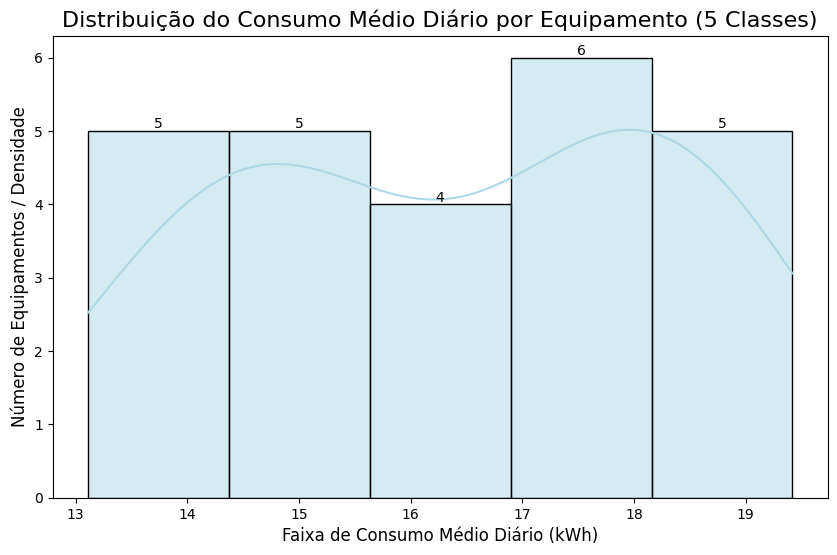


--- Tarefa 1 (Melhorada) Concluída ---
Estatísticas Descritivas do Consumo Médio Diário por Equipamento (kWh):
count    25.00
mean     16.40
std       1.98
min      13.11
25%      14.64
50%      16.65
75%      17.87
max      19.42
Name: consumo_medio_kwh, dtype: float64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker

# --- Assumindo que 'energy_daily_kwh' e 'consumo_medio_diario_per_equip' estão definidos ---
# Este bloco é apenas para tornar o exemplo executável. Remova-o ou adapte-o para seu código real.
if 'energy_daily_kwh' not in locals():
    # Simulação de energy_daily_kwh (para demonstração)
    equip_ids_sim = [f'Equipamento_{i+1:03d}' for i in range(25)] # 25 equipamentos
    dates_sim = pd.to_datetime(pd.date_range(start='2025-06-02', periods=30)) # 30 dias
    
    data_kwh_sim = {}
    for equip_id in equip_ids_sim:
        daily_vals = np.random.normal(loc=15 * 1000, scale=5 * 1000, size=len(dates_sim)) # Daily kWh
        daily_vals[daily_vals < 0] = 0
        data_kwh_sim[equip_id] = daily_vals
    energy_daily_kwh = pd.DataFrame(data_kwh_sim, index=dates_sim)
    energy_daily_kwh.index.name = 'timestamp'
    
    # Simulação de 'consumo_medio_diario_per_equip' (como seria gerado na Tarefa 1)
    consumo_medio_diario_per_equip = energy_daily_kwh.drop(columns=['timestamp'], errors='ignore').mean().reset_index()
    consumo_medio_diario_per_equip.columns = ['equipamento_id', 'consumo_medio_kwh']

# --- Fim da replicação de dados para exemplo ---


# --- Tarefa 1: Consumos Médios por Equipamento (Histograma Melhorado) ---

# Gerar o Histograma com 5 faixas (bins) e CURVA DE DISTRIBUIÇÃO (kde=True), com fundo transparente
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# sns.histplot:
# bins=5: Define que o histograma terá 5 barras (classes)
# kde=True: Plota a Curva de Densidade de Kernel (KDE), que suaviza a distribuição dos dados
sns.histplot(consumo_medio_diario_per_equip['consumo_medio_kwh'], ax=ax, bins=5, kde=True, color='lightblue', edgecolor='black')

# Opcional: Adicionar rótulos de contagem em cada barra (se o número de bins for pequeno)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax.set_title("Distribuição do Consumo Médio Diário por Equipamento (5 Classes)", fontsize=16)
ax.set_xlabel("Faixa de Consumo Médio Diário (kWh)", fontsize=12)
ax.set_ylabel("Número de Equipamentos / Densidade", fontsize=12) # Rótulo do Y agora inclui Densidade

# Remover notação científica do eixo X
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.ticklabel_format(style='plain', axis='y', useOffset=False) # Também no Y, se a densidade for alta

plt.savefig('histograma_consumo_medio_diario_equip_5bins_kde_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Tarefa 1 (Melhorada) Concluída ---")
print("Estatísticas Descritivas do Consumo Médio Diário por Equipamento (kWh):")
print(consumo_medio_diario_per_equip['consumo_medio_kwh'].describe().round(2))

Dispersao do consumo dos top 10 equipamentos 



--- Análise Extra: Boxplot dos Top 10 Equipamentos ---
Top 10 Equipamentos por Consumo Total no Período: ['idrac-9DQGPV3', 'SMV340208', 'SMV340211', 'SMV340262', 'SMV340204', 'idrac-DDQGPV3', 'SMV340205', 'SMV340210', 'idrac-CDQGPV3', 'SMV340209']


/var/folders/ml/t4j3y5sx31lfp68jb0y0zq9c0000gn/T/ipykernel_83142/4139337721.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='equipamento_id', y='consumo_kwh_diario', data=df_top_10_kwh_long,


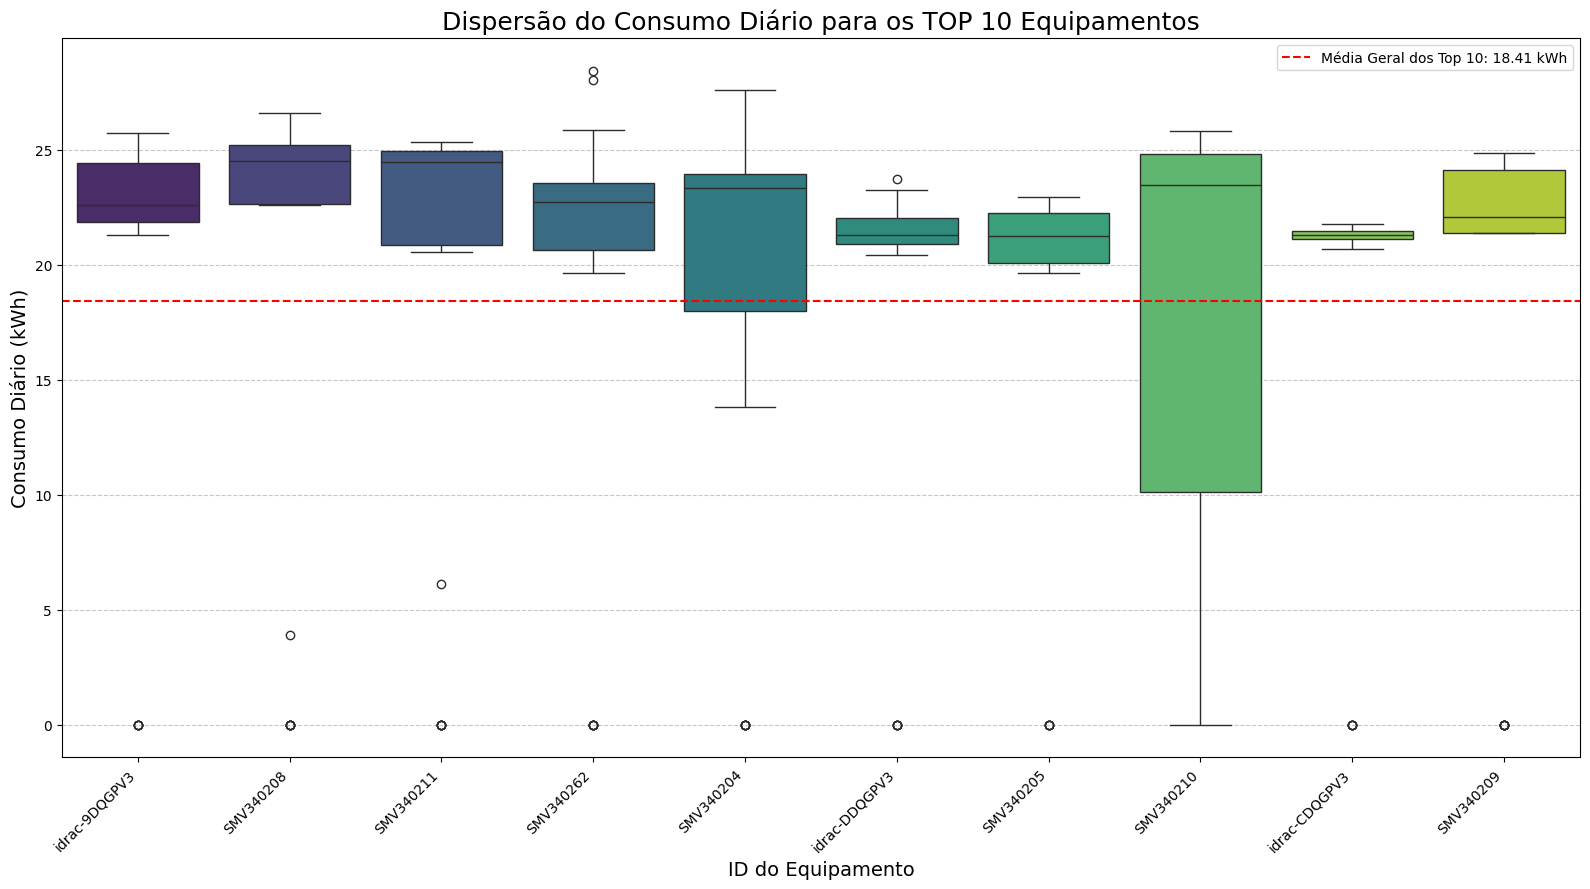


--- Análise Extra Concluída: Boxplot dos Top 10 Equipamentos ---
Este gráfico mostra a variabilidade diária de consumo para cada um dos 10 equipamentos que mais consomem.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker

# --- Assumindo que 'energy_daily_kwh' está disponível do passo de preparação inicial ---
# Este bloco é apenas para tornar o exemplo executável. Remova-o ou adapte-o para seu código real.
if 'energy_daily_kwh' not in locals():
    # Simulação de energy_daily_kwh (para demonstração)
    equip_ids_sim = [f'Equipamento_{i+1:03d}' for i in range(25)] # 25 equipamentos
    dates_sim = pd.to_datetime(pd.date_range(start='2025-06-02', periods=30)) # 30 dias
    
    data_kwh_sim = {}
    for equip_id in equip_ids_sim:
        daily_vals = np.random.normal(loc=15 * 1000, scale=5 * 1000, size=len(dates_sim))
        daily_vals[daily_vals < 0] = 0
        if int(equip_id.split('_')[1]) <= 5: # Make first 5 higher consumers for simulation
            daily_vals = np.random.normal(loc=25 * 1000, scale=7 * 1000, size=len(dates_sim))
        data_kwh_sim[equip_id] = daily_vals
    energy_daily_kwh = pd.DataFrame(data_kwh_sim, index=dates_sim)
    energy_daily_kwh.index.name = 'timestamp'
    print("energy_daily_kwh simulado para demonstração.")
# Fim da simulação para exemplo


# --- Análise Extra: Boxplot de Dispersão para os Top 10 Equipamentos ---

# 1. Identificar os Top 10 Equipamentos por Consumo TOTAL no Período
consumo_total_por_equip = energy_daily_kwh.drop(columns=['timestamp']).sum().reset_index()
consumo_total_por_equip.columns = ['equipamento_id', 'consumo_total_periodo_kwh']
top_10_equip_ids = consumo_total_por_equip.sort_values(by='consumo_total_periodo_kwh', ascending=False).head(10)['equipamento_id'].tolist()

print("\n--- Análise Extra: Boxplot dos Top 10 Equipamentos ---")
print(f"Top 10 Equipamentos por Consumo Total no Período: {top_10_equip_ids}")

# 2. Preparar Dados para o Boxplot (Formato Long)
df_top_10_kwh = energy_daily_kwh[['timestamp'] + top_10_equip_ids].copy()
df_top_10_kwh_long = pd.melt(df_top_10_kwh, 
                             id_vars=['timestamp'], 
                             var_name='equipamento_id', 
                             value_name='consumo_kwh_diario')

# Calcular a média geral de consumo DIÁRIO (para a linha de referência) APENAS para esses Top 10
media_geral_top_10 = df_top_10_kwh_long['consumo_kwh_diario'].mean()


# 3. Gerar o Boxplot com Fundo Transparente
fig, ax = plt.subplots(figsize=(16, 9))

# Definir o fundo da figura e dos eixos como totalmente transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Criar o Boxplot
sns.boxplot(x='equipamento_id', y='consumo_kwh_diario', data=df_top_10_kwh_long, 
            order=top_10_equip_ids, palette='viridis', ax=ax)

# --- CORREÇÃO AQUI: Chamar ax.axhline() diretamente ---
ax.axhline(y=media_geral_top_10, color='red', linestyle='--', 
            label=f'Média Geral dos Top 10: {media_geral_top_10:.2f} kWh') # Removido 'ax=ax'
# --- FIM DA CORREÇÃO ---

# Remover notação científica do eixo Y
plt.ticklabel_format(style='plain', axis='y', useOffset=False)

ax.set_title('Dispersão do Consumo Diário para os TOP 10 Equipamentos', fontsize=18)
ax.set_xlabel('ID do Equipamento', fontsize=14)
ax.set_ylabel('Consumo Diário (kWh)', fontsize=14)
ax.legend() # Exibe a legenda com a linha da média geral
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7) # Grid no eixo Y (já estava correto)
plt.tight_layout()

plt.savefig('boxplot_top10_consumo_diario_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Análise Extra Concluída: Boxplot dos Top 10 Equipamentos ---")
print("Este gráfico mostra a variabilidade diária de consumo para cada um dos 10 equipamentos que mais consomem.")

## Analisando o Consumo diário de Energia

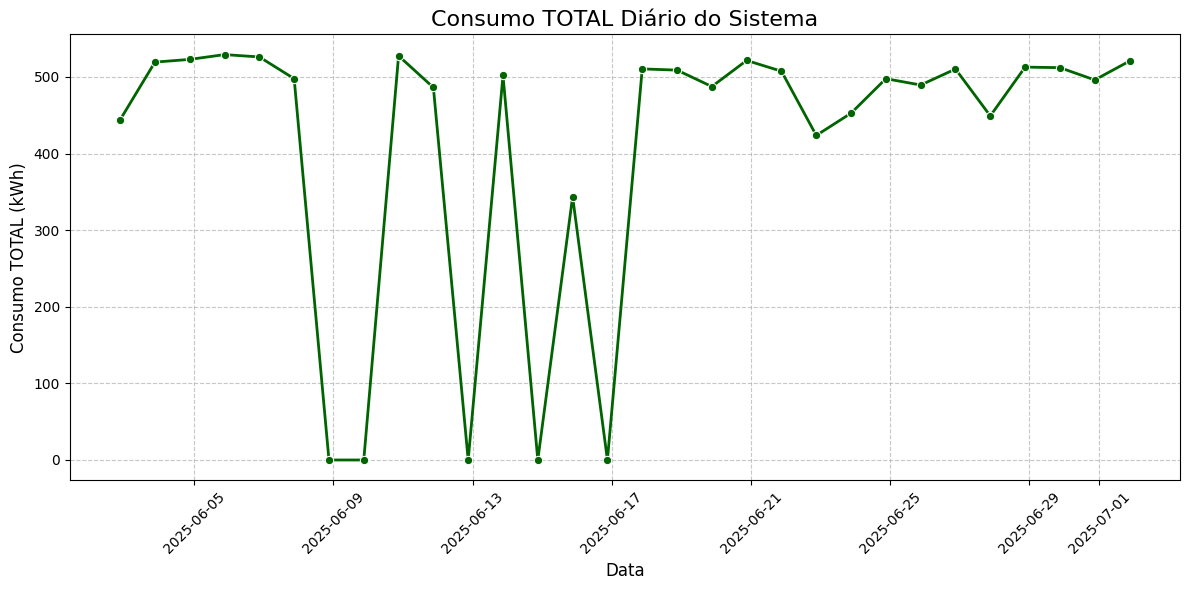


--- Tarefa 2 Concluída ---
Visão geral do Consumo TOTAL Diário do Sistema (kWh):
       consumo_total_kwh
count              30.00
mean              410.01
std               190.33
min                 0.00
25%               445.34
50%               497.76
75%               512.70
max               529.20


In [15]:
# Calcular o consumo TOTAL diário do sistema (somar o consumo de todos os equipamentos para cada dia)
total_daily_system_kwh = energy_daily_kwh.copy()
total_daily_system_kwh['consumo_total_kwh'] = total_daily_system_kwh.drop(columns=['timestamp']).sum(axis=1)

# Preparar o DataFrame para o gráfico
curva_consumo_total_diario = total_daily_system_kwh[['timestamp', 'consumo_total_kwh']]

# Gerar o Gráfico de Linha do Consumo TOTAL Diário com fundo transparente e grid
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

sns.lineplot(x='timestamp', y='consumo_total_kwh', data=curva_consumo_total_diario, marker='o', linewidth=2, color='darkgreen', ax=ax)

# Remover notação científica do eixo Y
plt.ticklabel_format(style='plain', axis='y')

ax.set_title("Consumo TOTAL Diário do Sistema", fontsize=16)
ax.set_ylabel("Consumo TOTAL (kWh)", fontsize=12)
ax.set_xlabel("Data", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('consumo_total_diario_sistema_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Tarefa 2 Concluída ---")
print("Visão geral do Consumo TOTAL Diário do Sistema (kWh):")
print(curva_consumo_total_diario.describe().round(2))

## Agrupamento de equipamentos por Faixa de Consumo 




--- Tarefa 4: Agrupamento de Equipamentos por Consumo Médio ---
Amostra dos equipamentos com seus grupos de consumo:
   equipamento_id  consumo_medio_kwh grupo_por_regra
19      SMV340263          13.379174   Baixo Consumo
4       SMV340204          18.642158   Médio Consumo
3       SMV340203          14.972251   Médio Consumo
17      SMV340234          14.641280   Médio Consumo
2       SMV340202          13.110461   Baixo Consumo


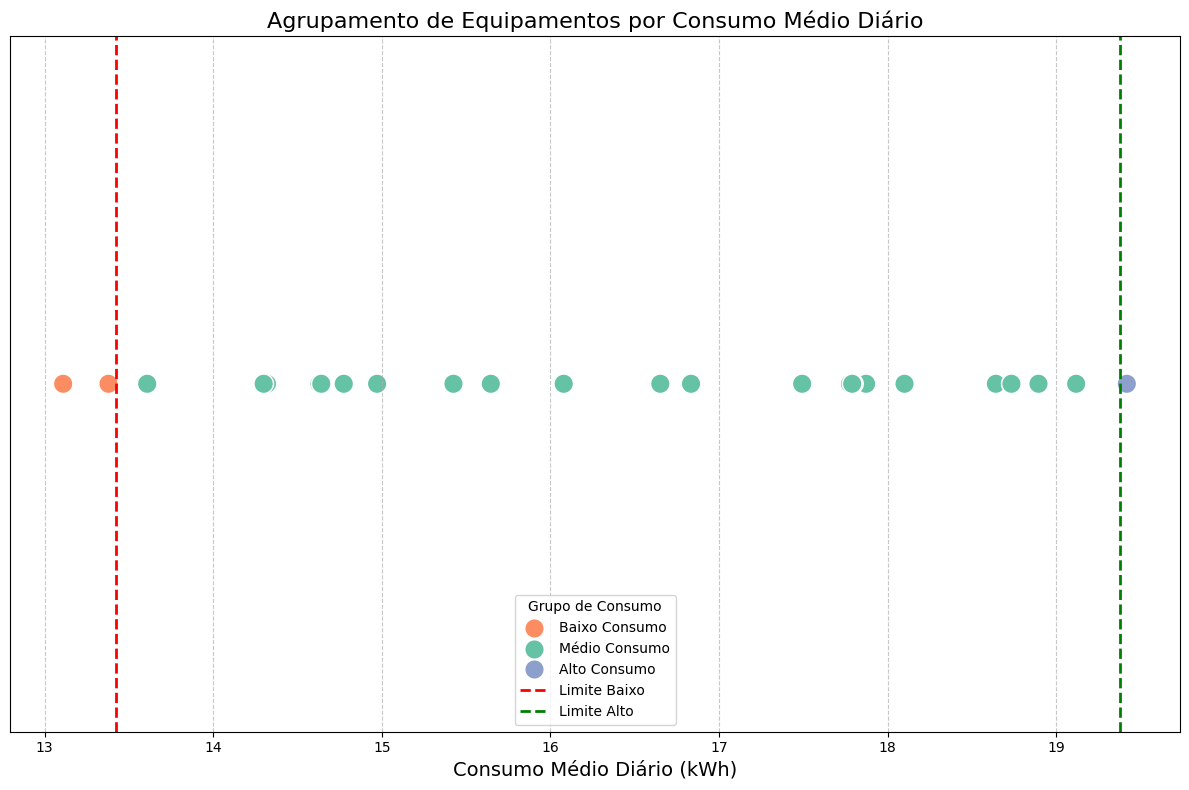


--- Tarefa 4 Concluída ---
Contagem de equipamentos por grupo:
grupo_por_regra
Médio Consumo    22
Baixo Consumo     2
Alto Consumo      1
Name: count, dtype: int64


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Assumindo que 'energy_daily_kwh' e 'consumo_medio_diario_per_equip' estão definidos ---
# Este bloco é apenas para tornar o exemplo executável. Remova-o ou adapte-o para seu código real.
if 'consumo_medio_diario_per_equip' not in locals():
    # Simulação de energy_daily_kwh (apenas para este exemplo de código)
    equip_ids_sim = [f'Equipamento_{i+1:03d}' for i in range(76)]
    dates_sim = pd.to_datetime(pd.date_range(start='2025-06-01', periods=7)) # 7 dias
    
    data_kwh_sim = {}
    for equip_id in equip_ids_sim:
        data_kwh_sim[equip_id] = np.random.normal(loc=15, scale=5, size=len(dates_sim)) * 1000 # Daily kWh
    
    energy_daily_kwh = pd.DataFrame(data_kwh_sim, index=dates_sim)
    energy_daily_kwh.index.name = 'timestamp'
    
    # Simulação de 'consumo_medio_diario_per_equip' (como seria gerado na Tarefa 1)
    consumo_medio_diario_per_equip = energy_daily_kwh.drop(columns=['timestamp'], errors='ignore').mean().reset_index()
    consumo_medio_diario_per_equip.columns = ['equipamento_id', 'consumo_medio_kwh']

# --- Fim da replicação de dados para exemplo ---


# --- Tarefa 4: Agrupamento de Equipamentos por Consumo Médio ---

# 1. Calcular a média e o desvio padrão do consumo médio diário de TODOS os equipamentos
media_geral_consumo = consumo_medio_diario_per_equip['consumo_medio_kwh'].mean()
std_geral_consumo = consumo_medio_diario_per_equip['consumo_medio_kwh'].std()

# 2. Definir os limites dos grupos usando a regra (1.5 desvios padrão)
limite_baixo_grupo = media_geral_consumo - 1.5 * std_geral_consumo
limite_alto_grupo = media_geral_consumo + 1.5 * std_geral_consumo

# 3. Aplicar a regra para criar a nova coluna 'grupo_por_regra' no DataFrame
consumo_medio_diario_per_equip['grupo_por_regra'] = np.where(
    consumo_medio_diario_per_equip['consumo_medio_kwh'] < limite_baixo_grupo, 'Baixo Consumo',
    np.where(consumo_medio_diario_per_equip['consumo_medio_kwh'] > limite_alto_grupo, 'Alto Consumo', 'Médio Consumo')
)

print("\n--- Tarefa 4: Agrupamento de Equipamentos por Consumo Médio ---")
print("Amostra dos equipamentos com seus grupos de consumo:")
print(consumo_medio_diario_per_equip.sample(5))

# 4. Visualização do Agrupamento (Scatter Plot para mostrar a distribuição dos pontos nos grupos)
fig, ax = plt.subplots(figsize=(12, 8))

# Definir o fundo da figura e dos eixos como totalmente transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Plotar os pontos (cada ponto é um equipamento), coloridos por grupo.
# Colocamos todos os pontos em uma linha horizontal no eixo Y (usando np.zeros) para focar na distribuição do eixo X.
sns.scatterplot(
    x='consumo_medio_kwh',
    y=np.zeros(consumo_medio_diario_per_equip.shape[0]), # Garante que todos os pontos estejam na mesma linha horizontal
    hue='grupo_por_regra',
    data=consumo_medio_diario_per_equip,
    palette='Set2', # Paleta de cores distinta para os 3 grupos
    s=200, # Tamanho dos pontos para melhor visibilidade
    ax=ax,
    legend='full' # Assegura que a legenda completa seja exibida
)

# Adicionar linhas verticais para os limites dos grupos (separadores)
plt.axvline(x=limite_baixo_grupo, color='red', linestyle='--', linewidth=2, label=f'Limite Baixo (< {limite_baixo_grupo:.2f} kWh)')
plt.axvline(x=limite_alto_grupo, color='green', linestyle='--', linewidth=2, label=f'Limite Alto (> {limite_alto_grupo:.2f} kWh)')

# Título e rótulos
ax.set_title('Agrupamento de Equipamentos por Consumo Médio Diário', fontsize=16)
ax.set_xlabel('Consumo Médio Diário (kWh)', fontsize=14)
ax.set_ylabel('') # O eixo Y não representa nada aqui, então o rótulo é vazio
ax.set_yticks([]) # Remove os ticks do eixo Y, já que todos os pontos estão em uma linha

# Remover notação científica do eixo X para facilitar a leitura dos valores
plt.ticklabel_format(style='plain', axis='x')

# Melhorar a legenda: Garante que os grupos (Baixo, Médio, Alto) apareçam em ordem e inclui as linhas de limite
handles, labels = ax.get_legend_handles_labels()
order = ['Baixo Consumo', 'Médio Consumo', 'Alto Consumo'] # Ordem desejada dos grupos
# Filtra e ordena os handles e labels da legenda
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in order]
sorted_handles_labels = sorted(filtered_handles_labels, key=lambda hl: order.index(hl[1]))
sorted_handles, sorted_labels = list(zip(*sorted_handles_labels)) if sorted_handles_labels else ([], []) # Desempacota e lida com lista vazia

# Adiciona as linhas dos limites à legenda
sorted_handles += (plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2),
                   plt.Line2D([0], [0], color='green', linestyle='--', linewidth=2))
sorted_labels += ('Limite Baixo', 'Limite Alto')

ax.legend(sorted_handles, sorted_labels, title='Grupo de Consumo')

plt.grid(True, axis='x', linestyle='--', alpha=0.7) # Adiciona grid apenas no eixo X para referência
plt.tight_layout()

plt.savefig('agrupamento_consumo_medio_equip_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Tarefa 4 Concluída ---")
print("Contagem de equipamentos por grupo:")
print(consumo_medio_diario_per_equip['grupo_por_regra'].value_counts())

# Agora agregaç±ao do consumo total 




--- Agrupamento por Consumo TOTAL do Período ---
Amostra dos equipamentos com seus grupos de consumo (Total do Período):
   equipamento_id  consumo_total_periodo_kwh grupo_por_regra_total
23  idrac-DDQGPV3                 543.011727         Médio Consumo
16      SMV340233                 438.907353         Médio Consumo
19      SMV340263                 401.375218         Baixo Consumo
0       SMV340200                 429.571334         Médio Consumo
3       SMV340203                 449.167518         Médio Consumo


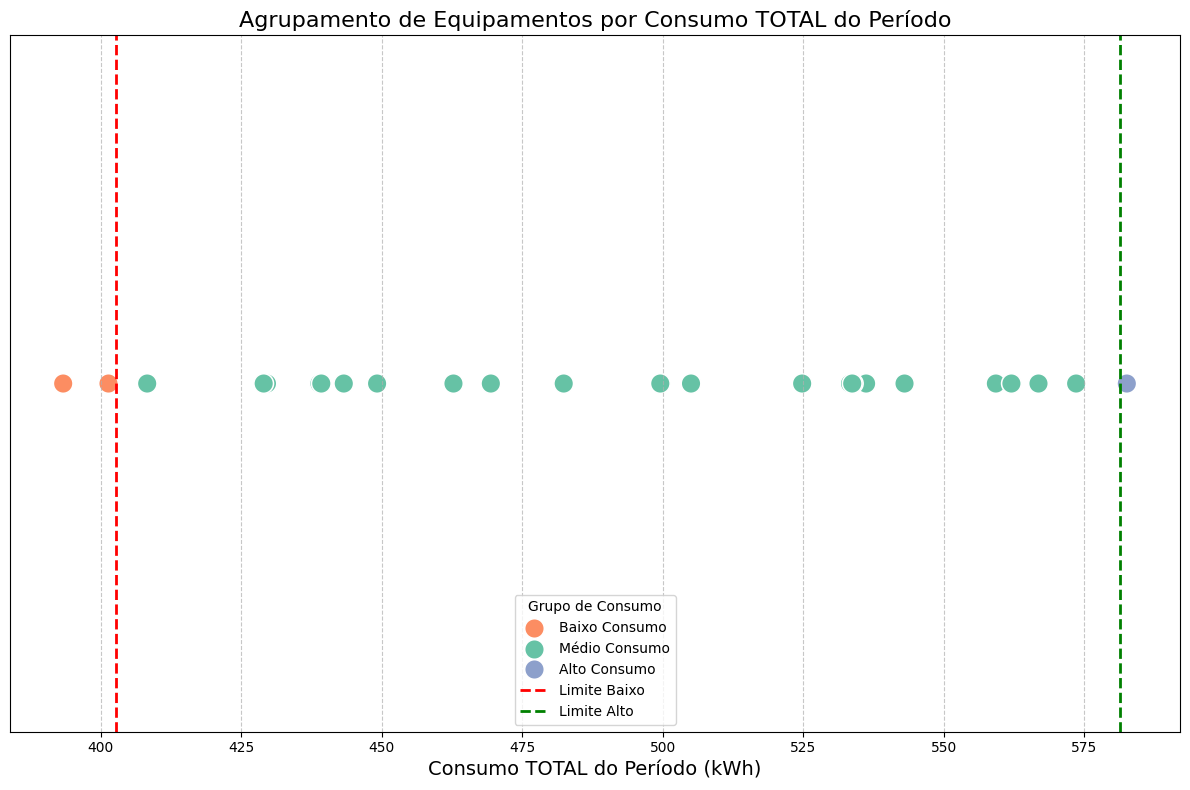


--- Tarefa Extra Concluída ---
Contagem de equipamentos por grupo (Consumo TOTAL do Período):
grupo_por_regra_total
Médio Consumo    22
Baixo Consumo     2
Alto Consumo      1
Name: count, dtype: int64


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Assumindo que 'energy_daily_kwh' está disponível do passo de preparação inicial ---
# Este bloco é apenas para tornar o exemplo executável. Remova-o ou adapte-o para seu código real.
if 'energy_daily_kwh' not in locals():
    # Simulação de energy_daily_kwh (para demonstração)
    equip_ids_sim = [f'Equipamento_{i+1:03d}' for i in range(76)]
    dates_sim = pd.to_datetime(pd.date_range(start='2025-06-01', periods=7)) # 7 dias
    
    data_kwh_sim = {}
    for equip_id in equip_ids_sim:
        # Simula consumo diário em kWh
        data_kwh_sim[equip_id] = np.random.normal(loc=15 * 1000, scale=5 * 1000, size=len(dates_sim)) # Convertendo para kWh (multiplicando por 1000 para valores mais altos)
    
    energy_daily_kwh = pd.DataFrame(data_kwh_sim, index=dates_sim)
    energy_daily_kwh.index.name = 'timestamp'

# --- Fim da replicação de dados para exemplo ---


# --- Tarefa Extra: Agrupamento por Consumo TOTAL do Período ---

# 1. Calcular o Consumo TOTAL de cada equipamento ao longo de TODO o período analisado
# Somamos o consumo diário de cada equipamento por todos os dias disponíveis no dataset.
consumo_total_periodo_por_equip = energy_daily_kwh.drop(columns=['timestamp'], errors='ignore').sum().reset_index()
consumo_total_periodo_por_equip.columns = ['equipamento_id', 'consumo_total_periodo_kwh']

# 2. Calcular a média e o desvio padrão do Consumo TOTAL do Período (de todos os equipamentos)
media_total_periodo = consumo_total_periodo_por_equip['consumo_total_periodo_kwh'].mean()
std_total_periodo = consumo_total_periodo_por_equip['consumo_total_periodo_kwh'].std()

# 3. Definir os limites dos grupos (1.5 desvios padrão abaixo e acima da média)
limite_baixo_periodo = media_total_periodo - 1.5 * std_total_periodo
limite_alto_periodo = media_total_periodo + 1.5 * std_total_periodo

# 4. Aplicar a regra para criar a nova coluna de agrupamento 'grupo_por_regra_total'
consumo_total_periodo_por_equip['grupo_por_regra_total'] = np.where(
    consumo_total_periodo_por_equip['consumo_total_periodo_kwh'] < limite_baixo_periodo, 'Baixo Consumo',
    np.where(consumo_total_periodo_por_equip['consumo_total_periodo_kwh'] > limite_alto_periodo, 'Alto Consumo', 'Médio Consumo')
)

print("\n--- Agrupamento por Consumo TOTAL do Período ---")
print("Amostra dos equipamentos com seus grupos de consumo (Total do Período):")
print(consumo_total_periodo_por_equip.sample(5))

# 5. Visualização do Agrupamento (Scatter Plot)
fig, ax = plt.subplots(figsize=(12, 8))

# Definir o fundo da figura e dos eixos como totalmente transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Plotar os pontos (cada ponto é um equipamento) coloridos pelo seu grupo
sns.scatterplot(
    x='consumo_total_periodo_kwh',
    y=np.zeros(consumo_total_periodo_por_equip.shape[0]), # Coloca todos os pontos em uma linha horizontal no eixo Y
    hue='grupo_por_regra_total',
    data=consumo_total_periodo_por_equip,
    palette='Set2', # Paleta de cores para os 3 grupos
    s=200, # Tamanho dos pontos
    ax=ax,
    legend='full' # Mostra a legenda completa
)

# Adicionar linhas verticais para os limites dos grupos (separadores)
plt.axvline(x=limite_baixo_periodo, color='red', linestyle='--', linewidth=2, label=f'Limite Baixo (< {limite_baixo_periodo:.2f} kWh)')
plt.axvline(x=limite_alto_periodo, color='green', linestyle='--', linewidth=2, label=f'Limite Alto (> {limite_alto_periodo:.2f} kWh)')

# Título e rótulos
ax.set_title('Agrupamento de Equipamentos por Consumo TOTAL do Período', fontsize=16)
ax.set_xlabel('Consumo TOTAL do Período (kWh)', fontsize=14)
ax.set_ylabel('') # Vazio, pois o eixo Y não tem significado quantitativo aqui
ax.set_yticks([]) # Remove os ticks do eixo Y

# Remover notação científica do eixo X
plt.ticklabel_format(style='plain', axis='x')

# Melhorar a legenda: Garante que os grupos (Baixo, Médio, Alto) apareçam em ordem e inclui as linhas de limite
handles, labels = ax.get_legend_handles_labels()
order = ['Baixo Consumo', 'Médio Consumo', 'Alto Consumo'] # Ordem desejada
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in order]
sorted_handles_labels = sorted(filtered_handles_labels, key=lambda hl: order.index(hl[1]))
sorted_handles, sorted_labels = list(zip(*sorted_handles_labels)) if sorted_handles_labels else ([], []) # Desempacota e lida com lista vazia

# Adiciona os handles e labels das linhas de limite à legenda
sorted_handles += (plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2),
                   plt.Line2D([0], [0], color='green', linestyle='--', linewidth=2))
sorted_labels += ('Limite Baixo', 'Limite Alto')

ax.legend(sorted_handles, sorted_labels, title='Grupo de Consumo')

plt.grid(True, axis='x', linestyle='--', alpha=0.7) # Grid apenas no eixo X
plt.tight_layout()

plt.savefig('agrupamento_consumo_total_periodo_equip_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Tarefa Extra Concluída ---")
print("Contagem de equipamentos por grupo (Consumo TOTAL do Período):")
print(consumo_total_periodo_por_equip['grupo_por_regra_total'].value_counts())

## Agregacao KMEANS com 5 grupos 




--- Agregação KMeans para 5 Grupos ---
Amostra dos equipamentos com seus novos grupos:
   equipamento_id  consumo_medio_kwh grupo_por_regra  grupo_kmeans_5  \
17      SMV340234          14.641280   Médio Consumo               0   
21  idrac-BDQGPV3          16.651944   Médio Consumo               4   
24  idrac-FDQGPV3          16.079098   Médio Consumo               4   
0       SMV340200          14.319044   Médio Consumo               0   
14      SMV340230          16.834158   Médio Consumo               4   

   grupo_kmeans_5_nome  
17     Grupo 2 (Baixo)  
21     Grupo 3 (Médio)  
24     Grupo 3 (Médio)  
0      Grupo 2 (Baixo)  
14     Grupo 3 (Médio)  


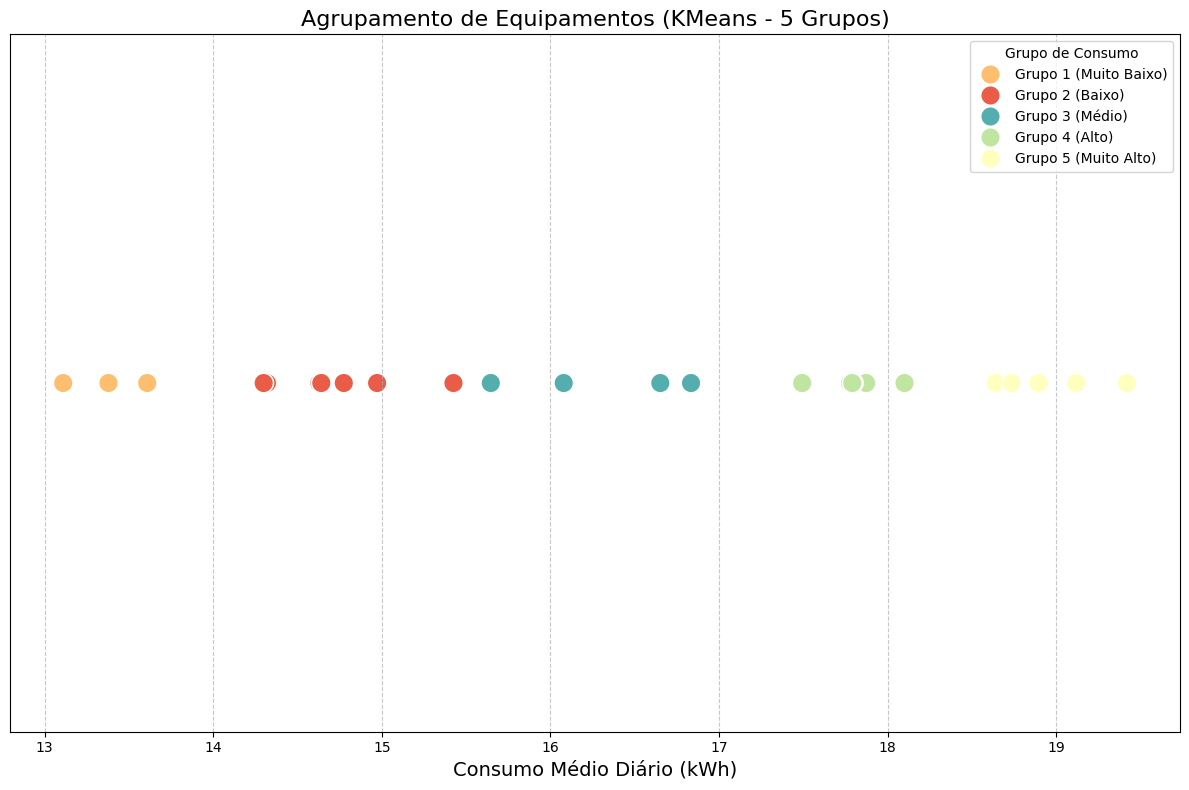


--- Análise de Agrupamento Concluída (KMeans 5 Grupos) ---
Contagem de equipamentos por grupo (KMeans 5 Grupos):
grupo_kmeans_5_nome
Grupo 1 (Muito Baixo)    3
Grupo 2 (Baixo)          7
Grupo 3 (Médio)          4
Grupo 4 (Alto)           6
Grupo 5 (Muito Alto)     5
Name: count, dtype: int64


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler # Para escalar os dados antes do KMeans
from sklearn.cluster import KMeans             # Para o algoritmo KMeans

# --- Assumindo que 'consumo_medio_diario_per_equip' está disponível ---
# (Gerado na Tarefa 1, a partir de energy_daily_kwh).
# Este bloco é apenas para tornar o exemplo executável. Remova-o ou adapte-o para seu código real.
if 'consumo_medio_diario_per_equip' not in locals():
    # Simulação de energy_daily_kwh (para demonstração)
    equip_ids_sim = [f'Equipamento_{i+1:03d}' for i in range(76)]
    dates_sim = pd.to_datetime(pd.date_range(start='2025-06-01', periods=7)) # 7 dias
    
    data_kwh_sim = {}
    for equip_id in equip_ids_sim:
        # Simula consumo diário em kWh
        data_kwh_sim[equip_id] = np.random.normal(loc=15 * 1000, scale=5 * 1000, size=len(dates_sim))
    
    energy_daily_kwh = pd.DataFrame(data_kwh_sim, index=dates_sim)
    energy_daily_kwh.index.name = 'timestamp'
    
    # Simulação de 'consumo_medio_diario_per_equip' (como seria gerado na Tarefa 1)
    consumo_medio_diario_per_equip = energy_daily_kwh.drop(columns=['timestamp'], errors='ignore').mean().reset_index()
    consumo_medio_diario_per_equip.columns = ['equipamento_id', 'consumo_medio_kwh']

# --- Fim da replicação de dados para exemplo ---


# --- Agregação KMeans para 5 Grupos ---

# 1. Preparar os dados para o clustering (usamos apenas a coluna de consumo médio)
X_cluster = consumo_medio_diario_per_equip[['consumo_medio_kwh']]
scaler = StandardScaler() # Importante: Escalar os dados antes do KMeans para que a distância funcione bem
X_scaled = scaler.fit_transform(X_cluster)

# 2. Aplicar o KMeans para 5 clusters
kmeans_5_grupos = KMeans(n_clusters=5, random_state=42, n_init=10) # n_init=10 evita warnings em versões recentes do sklearn
consumo_medio_diario_per_equip['grupo_kmeans_5'] = kmeans_5_grupos.fit_predict(X_scaled)

# 3. Mapear os clusters numéricos (0, 1, 2, 3, 4) para categorias descritivas
# Ordenamos pela média de consumo de cada cluster para dar nomes lógicos aos grupos
grupos_ordenados = consumo_medio_diario_per_equip.groupby('grupo_kmeans_5')['consumo_medio_kwh'].mean().sort_values().index
mapping_5_grupos = {
    grupos_ordenados[0]: 'Grupo 1 (Muito Baixo)',
    grupos_ordenados[1]: 'Grupo 2 (Baixo)',
    grupos_ordenados[2]: 'Grupo 3 (Médio)',
    grupos_ordenados[3]: 'Grupo 4 (Alto)',
    grupos_ordenados[4]: 'Grupo 5 (Muito Alto)'
}
consumo_medio_diario_per_equip['grupo_kmeans_5_nome'] = consumo_medio_diario_per_equip['grupo_kmeans_5'].map(mapping_5_grupos)

print("\n--- Agregação KMeans para 5 Grupos ---")
print("Amostra dos equipamentos com seus novos grupos:")
print(consumo_medio_diario_per_equip.sample(5))

# 4. Visualização do Agrupamento (Scatter Plot)
fig, ax = plt.subplots(figsize=(12, 8))

# Definir o fundo da figura e dos eixos como totalmente transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Plotar os pontos (cada ponto é um equipamento) coloridos pelo seu grupo
# Todos os pontos são plotados em uma linha horizontal no eixo Y (y=np.zeros)
sns.scatterplot(
    x='consumo_medio_kwh',
    y=np.zeros(consumo_medio_diario_per_equip.shape[0]),
    hue='grupo_kmeans_5_nome',
    data=consumo_medio_diario_per_equip,
    palette='Spectral', # Uma paleta de cores com mais distinção para 5 grupos
    s=200, # Tamanho dos pontos
    ax=ax,
    legend='full' # Garante que a legenda completa seja exibida
)

ax.set_title('Agrupamento de Equipamentos (KMeans - 5 Grupos)', fontsize=16)
ax.set_xlabel('Consumo Médio Diário (kWh)', fontsize=14)
ax.set_ylabel('') # Vazio, pois o eixo Y não tem significado quantitativo aqui
ax.set_yticks([]) # Remove os ticks do eixo Y

# Remover notação científica do eixo X
plt.ticklabel_format(style='plain', axis='x')

# Melhorar a legenda: Garante que os grupos apareçam na ordem lógica (Muito Baixo -> Muito Alto)
handles, labels = ax.get_legend_handles_labels()
ordered_labels = [mapping_5_grupos[g] for g in grupos_ordenados] # Ordem exata dos grupos
# Filtra e ordena os handles e labels para a legenda
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in ordered_labels]
sorted_handles_labels = sorted(filtered_handles_labels, key=lambda hl: ordered_labels.index(hl[1]))
sorted_handles, sorted_labels = list(zip(*sorted_handles_labels)) if sorted_handles_labels else ([], [])

ax.legend(sorted_handles, sorted_labels, title='Grupo de Consumo')


plt.grid(True, axis='x', linestyle='--', alpha=0.7) # Adiciona grid apenas no eixo X
plt.tight_layout()

plt.savefig('agrupamento_kmeans_5_grupos_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Análise de Agrupamento Concluída (KMeans 5 Grupos) ---")
print("Contagem de equipamentos por grupo (KMeans 5 Grupos):")
# Garante que a contagem dos grupos seja exibida na ordem correta também
print(consumo_medio_diario_per_equip['grupo_kmeans_5_nome'].value_counts().reindex(ordered_labels))

/var/folders/ml/t4j3y5sx31lfp68jb0y0zq9c0000gn/T/ipykernel_79251/2088057911.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


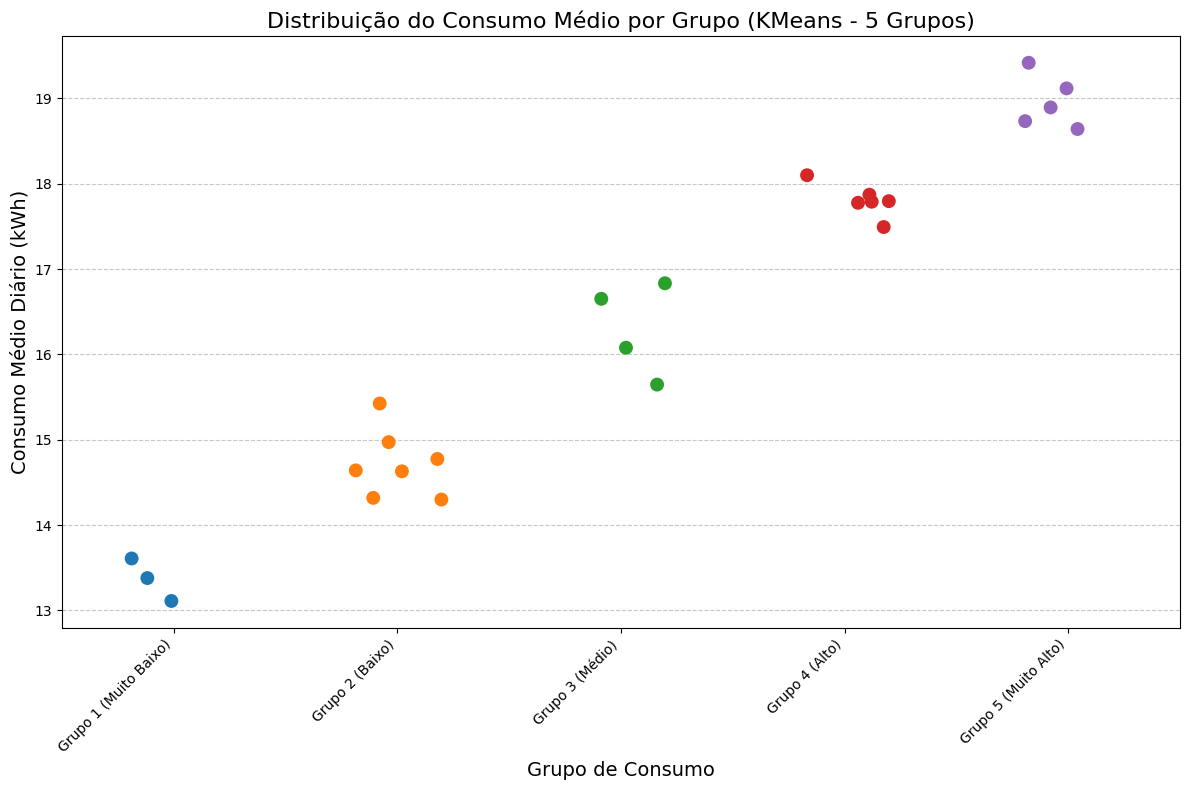

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Assumindo que 'consumo_medio_diario_per_equip' está disponível ---
# (gerado na Tarefa 1 e modificado com os resultados do KMeans 5 grupos).
# Este bloco é apenas para tornar o exemplo executável. Remova-o ou adapte-o para seu código real.
if 'consumo_medio_diario_per_equip' not in locals():
    # Simulação de energy_daily_kwh
    equip_ids_sim = [f'Equipamento_{i+1:03d}' for i in range(76)]
    dates_sim = pd.to_datetime(pd.date_range(start='2025-06-01', periods=7))
    data_kwh_sim = {}
    for equip_id in equip_ids_sim:
        data_kwh_sim[equip_id] = np.random.normal(loc=15000, scale=5000, size=len(dates_sim)) # Daily kWh
    energy_daily_kwh = pd.DataFrame(data_kwh_sim, index=dates_sim)
    energy_daily_kwh.index.name = 'timestamp'
    
    consumo_medio_diario_per_equip = energy_daily_kwh.drop(columns=['timestamp'], errors='ignore').mean().reset_index()
    consumo_medio_diario_per_equip.columns = ['equipamento_id', 'consumo_medio_kwh']

    # Aplica KMeans (o mesmo código da etapa anterior para 5 grupos)
    X_cluster = consumo_medio_diario_per_equip[['consumo_medio_kwh']]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    kmeans_5_grupos = KMeans(n_clusters=5, random_state=42, n_init=10)
    consumo_medio_diario_per_equip['grupo_kmeans_5'] = kmeans_5_grupos.fit_predict(X_scaled)
    grupos_ordenados = consumo_medio_diario_per_equip.groupby('grupo_kmeans_5')['consumo_medio_kwh'].mean().sort_values().index
    mapping_5_grupos = {
        grupos_ordenados[0]: 'Grupo 1 (Muito Baixo)',
        grupos_ordenados[1]: 'Grupo 2 (Baixo)',
        grupos_ordenados[2]: 'Grupo 3 (Médio)',
        grupos_ordenados[3]: 'Grupo 4 (Alto)',
        grupos_ordenados[4]: 'Grupo 5 (Muito Alto)'
    }
    consumo_medio_diario_per_equip['grupo_kmeans_5_nome'] = consumo_medio_diario_per_equip['grupo_kmeans_5'].map(mapping_5_grupos)

# --- Fim da replicação de dados para exemplo ---


# --- Nova Visualização: Strip Plot com Consumo na Vertical ---

fig, ax = plt.subplots(figsize=(12, 8))

# Definir o fundo da figura e dos eixos como totalmente transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Criar o Strip Plot
# x: o nome do grupo categórico (eixo horizontal)
# y: o valor numérico do consumo médio (eixo vertical)
# order: garante que os grupos apareçam na ordem lógica (Muito Baixo a Muito Alto)
# jitter=True: espalha um pouco os pontos para que não se sobreponham totalmente, mostrando a densidade
# palette: paleta de cores para os 5 grupos
sns.stripplot(
    x='grupo_kmeans_5_nome',
    y='consumo_medio_kwh',
    data=consumo_medio_diario_per_equip,
    order=[mapping_5_grupos[g] for g in grupos_ordenados], # Usar a ordem definida no mapeamento
    jitter=0.2, # Ajuste a quantidade de "espalhamento" se necessário
    palette='tab10', # Usar a mesma paleta do scatter anterior para consistência
    s=10, # Tamanho dos pontos (reduzido para melhor visualização)
    ax=ax
)

# Adicionar título e rótulos
ax.set_title('Distribuição do Consumo Médio por Grupo (KMeans - 5 Grupos)', fontsize=16)
ax.set_xlabel('Grupo de Consumo', fontsize=14)
ax.set_ylabel('Consumo Médio Diário (kWh)', fontsize=14)

# Remover notação científica do eixo Y (vertical)
plt.ticklabel_format(style='plain', axis='y')

# Rotacionar rótulos do eixo X se os nomes dos grupos forem longos
plt.xticks(rotation=45, ha='right')

# Adicionar grid apenas no eixo Y para referência de consumo
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Salvar o gráfico com fundo transparente
plt.savefig('stripplot_kmeans_5_grupos_vertical_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

# Tenatar um modelo preditivo de consumo de energia 




--- Tarefa 5: Preparação dos Dados para Regressão ---
Primeiras 5 linhas do DataFrame para Regressão:
                  timestamp  consumo_total_kwh_daily  \
0 2025-06-02 21:00:00-03:00               444.070272   
1 2025-06-03 21:00:00-03:00               519.385984   
2 2025-06-04 21:00:00-03:00               522.943992   
3 2025-06-05 21:00:00-03:00               529.204674   
4 2025-06-06 21:00:00-03:00               526.157699   

   quantidade_maquinas_ligadas_daily  
0                                 22  
1                                 25  
2                                 25  
3                                 25  
4                                 25  
Número de dias (observações): 30

--- Tarefa 5: Avaliação do Modelo de Regressão Linear ---
Coeficiente de Determinação (R²): 0.9934
Erro Quadrático Médio da Raiz (RMSE): 12.9044
Equação da Curva: Consumo Total Diário = -1.4051 + 20.7226 * Quantidade de Máquinas Diárias


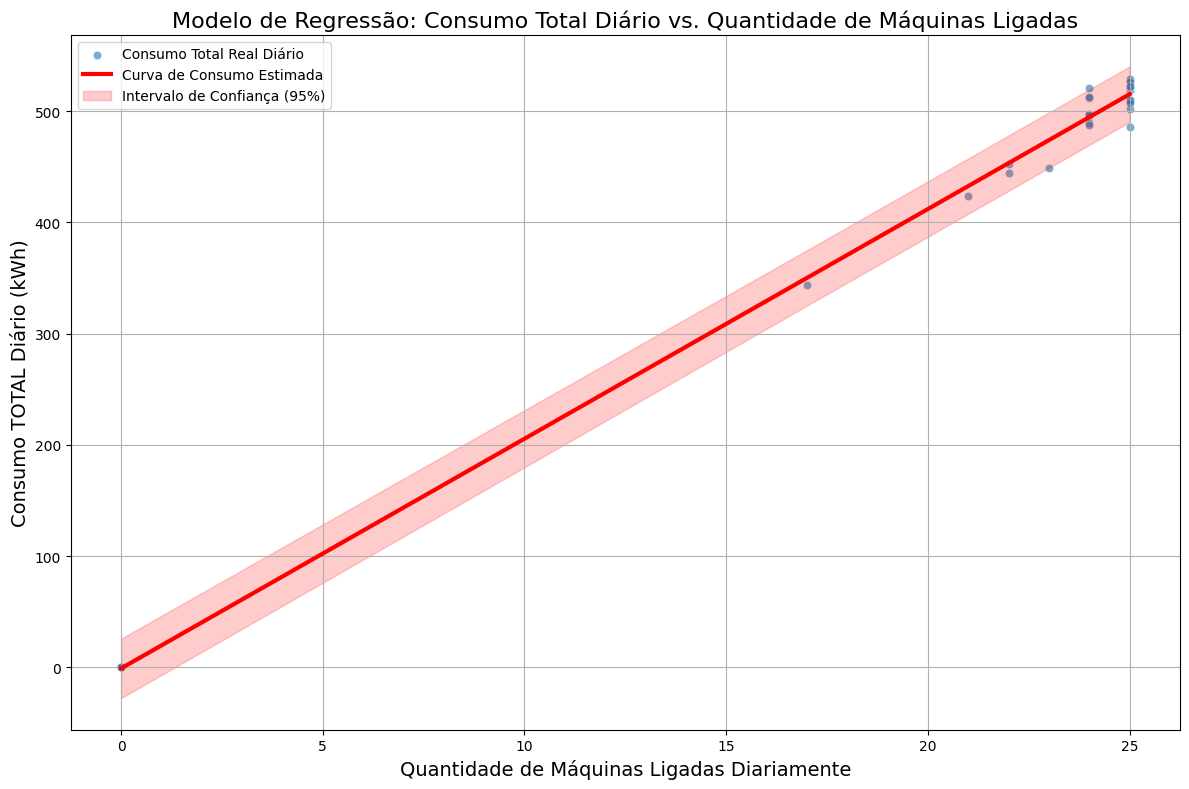


--- Tarefa 5 Concluída ---


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# --- Carregamento e Preparação Inicial do Dataset 1 ---
# Este bloco assume que energy_daily_kwh foi preparado conforme o último output de validação.
# Se você for rodar este bloco isoladamente, certifique-se de que energy_daily_kwh esteja definido.
# POR EXEMPLO:
# energy_daily_raw = pd.read_csv('nome_do_seu_arquivo_dataset1.csv')
# (adicione o código de renomeação, tratamento de NaN e conversão para kWh aqui)
# energy_daily_kwh = ... (resultado da preparação)

# Para tornar o código executável nesta célula se 'energy_daily_kwh' não estiver no ambiente:
if 'energy_daily_kwh' not in locals():
    # Simulação de energy_daily_kwh (para demonstração) - REMOVA NO SEU CÓDIGO REAL
    equip_ids_sim = [f'Equipamento_{i+1:03d}' for i in range(25)] # Apenas 25 equipamentos agora
    dates_sim = pd.to_datetime(pd.date_range(start='2025-06-02', periods=30)) # 30 dias
    
    data_kwh_sim = {}
    for equip_id in equip_ids_sim:
        daily_vals = np.random.normal(loc=15 * 1000, scale=5 * 1000, size=len(dates_sim)) # Simula consumo diário em kWh
        daily_vals[daily_vals < 0] = 0
        # Simula algumas máquinas "desligadas" (consumo 0)
        if np.random.rand() < 0.1: # 10% de chance de um equipamento ter dias com consumo 0
            daily_vals[np.random.choice(len(dates_sim), size=np.random.randint(1,3), replace=False)] = 0
        data_kwh_sim[equip_id] = daily_vals
    energy_daily_kwh = pd.DataFrame(data_kwh_sim, index=dates_sim)
    energy_daily_kwh.index.name = 'timestamp'
    print("energy_daily_kwh simulado para demonstração.")
# Fim da simulação para exemplo

# --- Tarefa 5: Modelo de Regressão Preditivo (Incremento por Adição de Equipamentos) ---

# 1. Preparar o DataFrame para o modelo de regressão
# Este DataFrame terá o timestamp, o consumo TOTAL do sistema por dia e a contagem de máquinas ligadas.

# Calcula o Consumo TOTAL do sistema por dia (kWh)
df_regressao_daily = energy_daily_kwh[['timestamp']].copy()
df_regressao_daily['consumo_total_kwh_daily'] = energy_daily_kwh.drop(columns=['timestamp']).sum(axis=1)

# Calcula a Quantidade de Máquinas Ligadas por dia
# Assumimos que se o consumo diário de um equipamento é > 0 kWh, ele estava "ligado" naquele dia.
# Contamos o número de colunas (equipamentos) com valor > 0 para cada linha (dia).
df_regressao_daily['quantidade_maquinas_ligadas_daily'] = (energy_daily_kwh.drop(columns=['timestamp']) > 0).sum(axis=1)

print("\n--- Tarefa 5: Preparação dos Dados para Regressão ---")
print("Primeiras 5 linhas do DataFrame para Regressão:")
print(df_regressao_daily.head())
print(f"Número de dias (observações): {df_regressao_daily.shape[0]}")


# 2. Treinar o Modelo de Regressão Linear
X = df_regressao_daily[['quantidade_maquinas_ligadas_daily']]
y = df_regressao_daily['consumo_total_kwh_daily']

# Divisão em conjuntos de treino e teste (mais robusta com 30 dias)
# test_size=0.3 significa 30% para teste (9 dias) e 70% para treino (21 dias).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo_reg_daily = LinearRegression()
modelo_reg_daily.fit(X_train, y_train)

# 3. Avaliar o Modelo
y_pred_daily = modelo_reg_daily.predict(X_test)

r2_daily = r2_score(y_test, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_test, y_pred_daily))

print("\n--- Tarefa 5: Avaliação do Modelo de Regressão Linear ---")
print(f"Coeficiente de Determinação (R²): {r2_daily:.4f}")
print(f"Erro Quadrático Médio da Raiz (RMSE): {rmse_daily:.4f}")
print(f"Equação da Curva: Consumo Total Diário = {modelo_reg_daily.intercept_:.4f} + {modelo_reg_daily.coef_[0]:.4f} * Quantidade de Máquinas Diárias")


# 4. Visualização da Regressão com Intervalo de Confiança
# Usamos Statsmodels para calcular o intervalo de confiança e o summary mais detalhado.
X_sm_daily = sm.add_constant(X) # Adiciona uma constante (o intercepto) para o Statsmodels
modelo_sm_daily = sm.OLS(y, X_sm_daily).fit() # Treina o modelo OLS (Ordinary Least Squares)

# Gerar as previsões e o intervalo de confiança de 95% para os valores previstos
previsoes_sm_daily = modelo_sm_daily.get_prediction(sm.add_constant(X))
previsoes_resumo_daily = previsoes_sm_daily.summary_frame(alpha=0.05) # alpha=0.05 para 95% de confiança

# Juntar os dados originais e as previsões para plotagem
curva_consumo_daily = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True), previsoes_resumo_daily[['mean', 'obs_ci_lower', 'obs_ci_upper']]], axis=1)
curva_consumo_daily.columns = ['quantidade_maquinas_ligadas_daily', 'consumo_total_real_daily', 'consumo_total_previsto_daily', 'limite_inferior_conf', 'limite_superior_conf']
curva_consumo_daily = curva_consumo_daily.sort_values(by='quantidade_maquinas_ligadas_daily')

fig, ax = plt.subplots(figsize=(12, 8))

# Definir o fundo da figura e dos eixos como totalmente transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Plotar os pontos de consumo total real por dia
sns.scatterplot(x='quantidade_maquinas_ligadas_daily', y='consumo_total_real_daily', data=curva_consumo_daily, label='Consumo Total Real Diário', alpha=0.6, ax=ax)

# Plotar a linha de regressão
# CORREÇÃO: Chamar o método 'plot' DIRETAMENTE do objeto 'ax'
ax.plot(curva_consumo_daily['quantidade_maquinas_ligadas_daily'], curva_consumo_daily['consumo_total_previsto_daily'], color='red', linewidth=3, label='Curva de Consumo Estimada')

# Adicionar a faixa sombreada do intervalo de confiança
# CORREÇÃO: Chamar o método 'fill_between' DIRETAMENTE do objeto 'ax'
ax.fill_between(curva_consumo_daily['quantidade_maquinas_ligadas_daily'], curva_consumo_daily['limite_inferior_conf'], curva_consumo_daily['limite_superior_conf'], color='red', alpha=0.2, label='Intervalo de Confiança (95%)')

# Remover notação científica do eixo Y
plt.ticklabel_format(style='plain', axis='y', useOffset=False)

ax.set_title('Modelo de Regressão: Consumo Total Diário vs. Quantidade de Máquinas Ligadas', fontsize=16)
ax.set_xlabel('Quantidade de Máquinas Ligadas Diariamente', fontsize=14)
ax.set_ylabel('Consumo TOTAL Diário (kWh)', fontsize=14)
ax.legend()
ax.grid(True)
plt.tight_layout()

plt.savefig('regressao_consumo_total_diario_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Tarefa 5 Concluída ---")

## Acrescentando 100 maquinas 




--- Tarefa 6: Comparativo de Previsão para 100 Máquinas ---
Previsão do Modelo de Regressão: 2070.86 kWh
Previsão pela Média Simples: 1640.05 kWh


/Users/william/minilab/powermanager/lts311/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/ml/t4j3y5sx31lfp68jb0y0zq9c0000gn/T/ipykernel_79251/179832557.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=valores, palette='coolwarm', ax=ax)


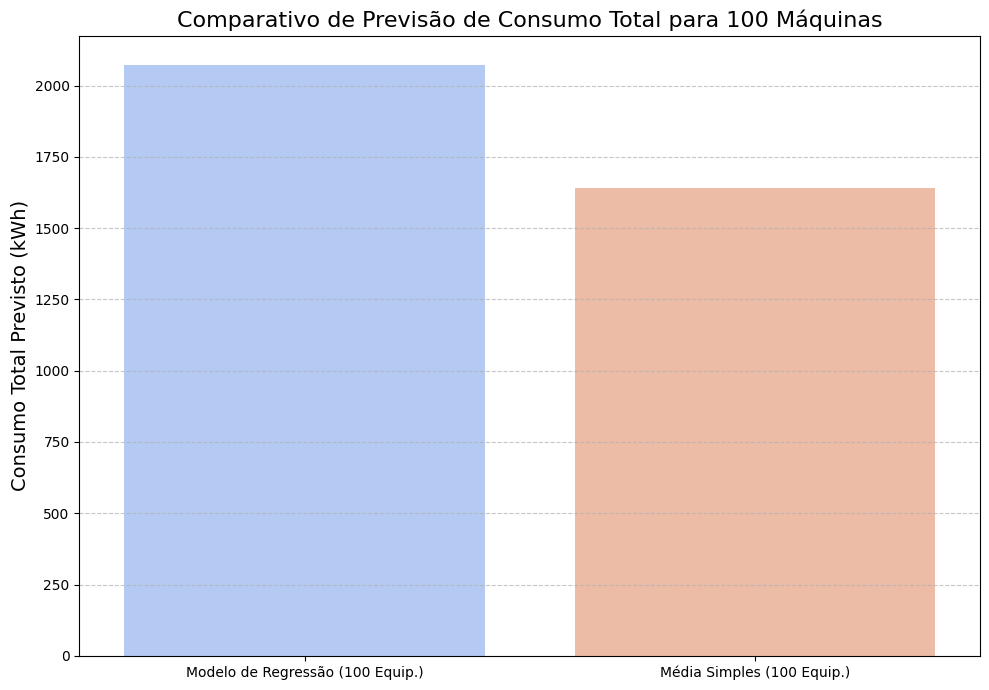


--- Tarefa 6 Concluída ---


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression # Assumindo que essas libs já estão importadas
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# --- Assumindo que 'energy_daily_kwh', 'modelo_reg_daily', 'consumo_medio_diario_per_equip' estão definidos ---
# Este bloco é apenas para tornar o exemplo executável. Remova-o ou adapte-o para seu código real.
if 'modelo_reg_daily' not in locals():
    # Simulação de energy_daily_kwh (para demonstração)
    equip_ids_sim = [f'Equipamento_{i+1:03d}' for i in range(25)] # 25 equipamentos
    dates_sim = pd.to_datetime(pd.date_range(start='2025-06-02', periods=30)) # 30 dias
    
    data_kwh_sim = {}
    for equip_id in equip_ids_sim:
        daily_vals = np.random.normal(loc=20 * 1000, scale=5 * 1000, size=len(dates_sim)) # Daily kWh
        daily_vals[daily_vals < 0] = 0
        if np.random.rand() < 0.1:
            daily_vals[np.random.choice(len(dates_sim), size=np.random.randint(1,3), replace=False)] = 0
        data_kwh_sim[equip_id] = daily_vals
    energy_daily_kwh = pd.DataFrame(data_kwh_sim, index=dates_sim)
    energy_daily_kwh.index.name = 'timestamp'

    # Simulação de df_regressao_daily e modelo_reg_daily para demonstração
    df_regressao_daily = energy_daily_kwh[['timestamp']].copy()
    df_regressao_daily['consumo_total_kwh_daily'] = energy_daily_kwh.drop(columns=['timestamp']).sum(axis=1)
    df_regressao_daily['quantidade_maquinas_ligadas_daily'] = (energy_daily_kwh.drop(columns=['timestamp']) > 0).sum(axis=1)
    X = df_regressao_daily[['quantidade_maquinas_ligadas_daily']]
    y = df_regressao_daily['consumo_total_kwh_daily']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    modelo_reg_daily = LinearRegression()
    modelo_reg_daily.fit(X_train, y_train)

    # Simulação de consumo_medio_diario_per_equip
    consumo_medio_diario_per_equip = energy_daily_kwh.drop(columns=['timestamp']).mean().reset_index()
    consumo_medio_diario_per_equip.columns = ['equipamento_id', 'consumo_medio_kwh']

# --- Fim da replicação de dados para exemplo ---


# --- Tarefa 6: Gráfico Comparativo do Consumo Total Estimado para 100 Máquinas ---

# 1. Calcular a Previsão do Modelo de Regressão para 100 máquinas
num_maquinas_para_prever = 100
# O modelo espera um array 2D para a entrada X
previsao_modelo_regressao = modelo_reg_daily.predict(np.array([[num_maquinas_para_prever]]))[0] # [0] para pegar o valor escalar

# 2. Calcular a Previsão pela Média Simples para 100 máquinas
# Média do consumo médio diário por equipamento (calculada na Tarefa 1)
media_diaria_por_equip = consumo_medio_diario_per_equip['consumo_medio_kwh'].mean()
previsao_media_simples = media_diaria_por_equip * num_maquinas_para_prever

print(f"\n--- Tarefa 6: Comparativo de Previsão para {num_maquinas_para_prever} Máquinas ---")
print(f"Previsão do Modelo de Regressão: {previsao_modelo_regressao:.2f} kWh")
print(f"Previsão pela Média Simples: {previsao_media_simples:.2f} kWh")

# 3. Gerar o Gráfico Comparativo
labels = [f'Modelo de Regressão ({num_maquinas_para_prever} Equip.)', f'Média Simples ({num_maquinas_para_prever} Equip.)']
valores = [previsao_modelo_regressao, previsao_media_simples]

fig, ax = plt.subplots(figsize=(10, 7))

# Definir o fundo da figura e dos eixos como totalmente transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

sns.barplot(x=labels, y=valores, palette='coolwarm', ax=ax)

# Remover notação científica do eixo Y
plt.ticklabel_format(style='plain', axis='y', useOffset=False)

ax.set_title(f'Comparativo de Previsão de Consumo Total para {num_maquinas_para_prever} Máquinas', fontsize=16)
ax.set_ylabel('Consumo Total Previsto (kWh)', fontsize=14)
ax.set_xlabel('') # Remover rótulo do eixo X, pois as labels das barras já são claras
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adicionar grid no eixo Y
plt.tight_layout()

plt.savefig('comparativo_previsao_100_maquinas_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Tarefa 6 Concluída ---")

## Consumo por hora 



Dataset './data/PowerConsAvg.csv' carregado com sucesso.

Dataset 'power_15min_avg_w' (Potência Média em W) após preparação inicial (5 primeiras linhas):
            timestamp   SMV340200   SMV340201   SMV340202   SMV340203  \
0 2025-06-02 13:30:00  703.312169  725.310527  710.147369  743.731579   
1 2025-06-02 13:45:00  704.378948  725.984127  710.057894  744.084210   
2 2025-06-02 14:00:00  718.115790  741.110527  723.052631  779.021164   
3 2025-06-02 14:15:00  704.629630  733.478948  726.378948  753.794737   
4 2025-06-02 14:30:00  707.557894  738.378948  716.610527  754.652631   

     SMV340204   SMV340205   SMV340206   SMV340207    SMV340208  ...  \
0  1091.650793  803.521052  804.663158  860.280423   961.563158  ...   
1  1008.058201  803.568421  802.015790  854.126984   982.510527  ...   
2  1045.900000  807.989473  806.005236  853.984210  1007.285714  ...   
3  1195.984127  814.147369  805.642106  859.375661  1019.094737  ...   
4  1150.900000  811.885588  807.389473  865.136

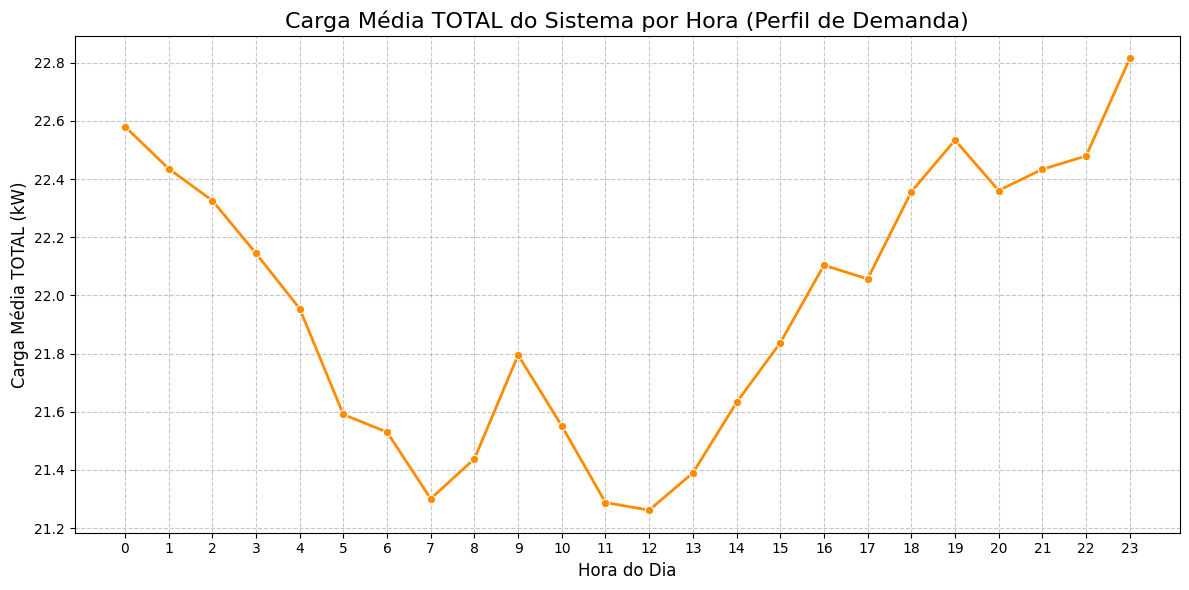


--- Tarefa 3 Concluída ---
Estatísticas do Consumo Médio TOTAL do Sistema por Hora (Watts):
       hora_do_dia  consumo_total_kw
count        24.00             24.00
mean         11.50             21.97
std           7.07              0.48
min           0.00             21.26
25%           5.75             21.55
50%          11.50             22.01
75%          17.25             22.38
max          23.00             22.81


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# --- 0. Carregamento e Preparação Inicial do Dataset 2 ---
# Substitua 'nome_do_seu_arquivo_dataset2.csv' pelo nome real do seu arquivo CSV.
nome_arquivo_dataset2 = './data/PowerConsAvg.csv'

try:
    power_15min_raw = pd.read_csv(nome_arquivo_dataset2)
    print(f"Dataset '{nome_arquivo_dataset2}' carregado com sucesso.")
except FileNotFoundError:
    print(f"\nERRO: O arquivo '{nome_arquivo_dataset2}' não foi encontrado.")
    print("Por favor, verifique o nome do arquivo e se ele está na mesma pasta do seu script/notebook.")
    exit()
except Exception as e:
    print(f"\nOcorreu um erro ao carregar ou processar o arquivo: {e}")
    exit()

# 1. Renomear a coluna de data/hora para 'timestamp'
power_15min_raw.rename(columns={"Date and time": "timestamp"}, inplace=True)

# 2. Converter 'timestamp' para datetime e remover informação de fuso horário
power_15min_raw['timestamp'] = pd.to_datetime(power_15min_raw['timestamp']).dt.tz_convert(None) 

# Restante do código de preparação...
equipment_cols_full_names_power = power_15min_raw.columns[1:]
equipment_ids_power = [col.split(" - Power Consumption")[0] for col in equipment_cols_full_names_power]
power_15min_raw.columns = ['timestamp'] + equipment_ids_power
for col in equipment_ids_power:
    power_15min_raw[col] = pd.to_numeric(power_15min_raw[col], errors='coerce')
power_15min_raw.fillna(0, inplace=True)
power_15min_avg_w = power_15min_raw.copy()

print("\nDataset 'power_15min_avg_w' (Potência Média em W) após preparação inicial (5 primeiras linhas):")
print(power_15min_avg_w.head())



### **Tarefa 3: Distribuição do Consumo por Hora ao longo do Dia (Código Corrigido)**


# 1. Calcular o Consumo TOTAL do sistema para cada timestamp (somando todos os equipamentos)
# CORREÇÃO CRUCIAL AQUI:
# Usamos .set_index('timestamp') para que o timestamp seja o índice, somamos as colunas,
# e depois .reset_index() para transformar o timestamp de volta em uma coluna.
consumo_total_w_por_timestamp = power_15min_avg_w.set_index('timestamp').sum(axis=1).reset_index()
consumo_total_w_por_timestamp.columns = ['timestamp', 'consumo_total_w'] # Garante os nomes corretos
consumo_total_w_por_timestamp['consumo_total_kw'] = consumo_total_w_por_timestamp['consumo_total_w'] / 1000
# 2. Extrair a hora do dia do timestamp (AGORA FUNCIONARÁ!)
consumo_total_w_por_timestamp['hora_do_dia'] = consumo_total_w_por_timestamp['timestamp'].dt.hour

# 3. Agrupar pela hora do dia e calcular a MÉDIA do consumo TOTAL do sistema para cada hora.
# consumo_medio_total_horario_w = consumo_total_w_por_timestamp.groupby('hora_do_dia')['consumo_total_w'].mean().reset_index()

consumo_medio_total_horario_w = consumo_total_w_por_timestamp.groupby('hora_do_dia')['consumo_total_kw'].mean().reset_index()


# --- Geração do Gráfico com Fundo Transparente e Grid ---

fig, ax = plt.subplots(figsize=(12, 6))

# Definir o fundo da figura e dos eixos como totalmente transparente
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Plotar a linha de Consumo Médio TOTAL por Hora (em Watts)
# sns.lineplot(x='hora_do_dia', y='consumo_total_w', data=consumo_medio_total_horario_w, marker='o', linewidth=2, color='darkorange', ax=ax)
sns.lineplot(x='hora_do_dia', y='consumo_total_kw', data=consumo_medio_total_horario_w, marker='o', linewidth=2, color='darkorange', ax=ax)

# Altere a linha do título:
ax.set_title("Carga Média TOTAL do Sistema por Hora (Perfil de Demanda)", fontsize=16)

# Altere a linha do rótulo do eixo Y:
ax.set_ylabel("Carga Média TOTAL (kW)", fontsize=12)


# Remover notação científica do eixo Y
plt.ticklabel_format(style='plain', axis='y', useOffset=False)

# ax.set_title("Consumo Médio TOTAL do Sistema por Hora (Agregado de Todos os Dias)", fontsize=16)
# ax.set_ylabel("Consumo Médio TOTAL (W)", fontsize=12) # Unidade em Watts
ax.set_xlabel("Hora do Dia", fontsize=12)

plt.xticks(range(0, 24)) # Garantir que todas as horas de 0 a 23 sejam exibidas
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('consumo_medio_total_horario_kw_transparente.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

print("\n--- Tarefa 3 Concluída ---")
print("Estatísticas do Consumo Médio TOTAL do Sistema por Hora (Watts):")
print(consumo_medio_total_horario_w.describe().round(2))